In [797]:
%run ../../preamble.py # opgelet, dit laadt alles in van qutip al.
%run ../../analytics.py 

import scipy.integrate as integr

In [798]:
%matplotlib widget
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
custom_preamble = {
            "text.usetex": True,
            "font.size" : 10,
            "text.latex.preamble": r"\usepackage{amsmath} \usepackage{bbold} \usepackage{amssymb} \usepackage{mathrsfs} \usepackage{physics} \usepackage{mathtools}"}
plt.rcParams.update(custom_preamble)

Gewoon voor wat inspiratie uit te halen, hier is de subroutine van mijn thesis:

```python
def integrate(times, **integrationParameters):  # wanneer wordt deze nog gebruikt?
    '''Returns a method that accepts a vector field, and returns the flow at a certain time step specified here. For now only used to construct Poincare maps of periodic vector fields.'''
    def decoratorken(f):
        def P(X): 
            parameters = dict(list(STANDARD_INTEGRATION_PARAMETERS.items()) + list(integrationParameters.items())) # de tweede overschrijft de eerste !!

            ################## PYTHON NUMERICAL INTEGRATION ALGORITHM #############
            return integr.solve_ivp(f, times, X, vectorized=False, **parameters).y[:,-1]
            #######################################################################
        return P
    return decoratorken
````


In [799]:
### define all the parameters
kappa = 0.1 ; kappa_c = 1 ; n_c = 100

eta_0 = 2.15
eta_0 = 3
eta_0 = 2.4

dw = 0.3
dw = 0.0
dw = 1

phi = np.pi
phi = np.pi / 20
phi = 0

epsilon_1 = 0
epsilon_2 = 0

In [800]:
### define the vector field(s)
def vf_cross_gain(_, X):
    '''This is the version that I (Michiel) thought corresponded to the code Juan sent out.'''
    # first go to complex variables
    alpha_1 = X[0] + 1j * X[1]
    alpha_2 = X[2] + 1j * X[3]

    # then define the complex vector field
    alpha_1_dot = - (kappa + 2 * kappa_c - kappa_c * eta_0 / (1 + np.abs(alpha_2)**2 / n_c) + 1j * dw) * alpha_1 \
                  - 1j * kappa_c * eta_0 / (1 + np.abs(alpha_2)**2 / n_c) * alpha_2 + epsilon_1
    alpha_2_dot = - (kappa + 2 * kappa_c - kappa_c * eta_0 / (1 + np.abs(alpha_1)**2 / n_c) + 1j * dw) * alpha_2 \
                  - 1j * kappa_c * eta_0 / (1 + np.abs(alpha_1)**2 / n_c) * np.exp(1j * phi) * alpha_1 + epsilon_2

    # then return in the (4D) real representation
    return np.array([np.real(alpha_1_dot), np.imag(alpha_1_dot), np.real(alpha_2_dot), np.imag(alpha_2_dot)])

def vf_onsite_gain(_, X):
    '''Version that we seemed to lean towards during the last meeting at Lorenza's office; Vincent also thought this was the one?'''
    # first go to complex variables
    alpha_1 = X[0] + 1j * X[1]
    alpha_2 = X[2] + 1j * X[3]

    # then define the complex vector field
    alpha_1_dot = - (kappa + 2 * kappa_c - kappa_c * eta_0 / (1 + np.abs(alpha_1)**2 / n_c) + 1j * dw) * alpha_1 \
                  - 1j * kappa_c * eta_0 / (1 + np.abs(alpha_2)**2 / n_c) * alpha_2 + epsilon_1
    alpha_2_dot = - (kappa + 2 * kappa_c - kappa_c * eta_0 / (1 + np.abs(alpha_2)**2 / n_c) + 1j * dw) * alpha_2 \
                  - 1j * kappa_c * eta_0 / (1 + np.abs(alpha_1)**2 / n_c) * np.exp(1j * phi) * alpha_1 + epsilon_2

    # then return in the (4D) real representation
    return np.array([np.real(alpha_1_dot), np.imag(alpha_1_dot), np.real(alpha_2_dot), np.imag(alpha_2_dot)])

In [801]:
### set an initial condition


# I want the beta_m mode to basically be zero in the intitial condition
beta_p_0 = 0.02 + 1j * 0.01

beta_m_0 = 0.05 + 0.02 * 1j # zou dan onstabiel moeten zijn.
beta_m_0 = 0.001 + 0.002 * 1j # zou dan onstabiel moeten zijn.
beta_m_0 = 0.0001 + 0.0002 * 1j # zou dan onstabiel moeten zijn.
beta_m_0 = 0.00001 + 0.00002 * 1j # zou dan onstabiel moeten zijn.
beta_m_0 = 0.000001 + 0.000002 * 1j # zou dan onstabiel moeten zijn.
beta_m_0 = 0.0000001 + 0.0000002 * 1j # zou dan onstabiel moeten zijn.
beta_m_0 = 0.
beta_m_0 = 1e-16

# help functions
def normal_to_lab_amplitudes(beta_p, beta_m):
    '''go from normal- to lab-mode amplitudes'''
    alpha_1 = (beta_p + beta_m) / np.sqrt(2)
    alpha_2 = np.exp(1j * phi / 2) * (beta_p - beta_m) / np.sqrt(2)
    return alpha_1, alpha_2

def lab_to_normal_amplitudes(alpha_1, alpha_2):
    '''go from lab- to normal-mode amplitudes'''
    beta_p = (alpha_1 + np.exp(- 1j * phi / 2) * alpha_2) / np.sqrt(2)
    beta_m = (alpha_1 - np.exp(- 1j * phi / 2) * alpha_2) / np.sqrt(2)
    return beta_p, beta_m

# Finalize
alpha_1_0, alpha_2_0 = normal_to_lab_amplitudes(beta_p_0, beta_m_0)
X_0 = np.array([np.real(alpha_1_0), np.imag(alpha_1_0), np.real(alpha_2_0), np.imag(alpha_2_0)])

In [802]:
### Now we can integrate the system

# time vector
times = np.linspace(0, 50, 10000)
times = np.array(times)

onsite_gain_solution = integr.solve_ivp(vf_onsite_gain, [times[0], times[-1]], X_0, t_eval=times)
cross_gain_solution  = integr.solve_ivp(vf_cross_gain,  [times[0], times[-1]], X_0, t_eval=times)

Text(0.5, 0.98, "Solution for cross-gain model ``$\\dot{\\alpha}_{1/2} = \\cdots + G(|\\alpha_{2/1}|^2) \\alpha_{1/2} + \\cdots$.''")

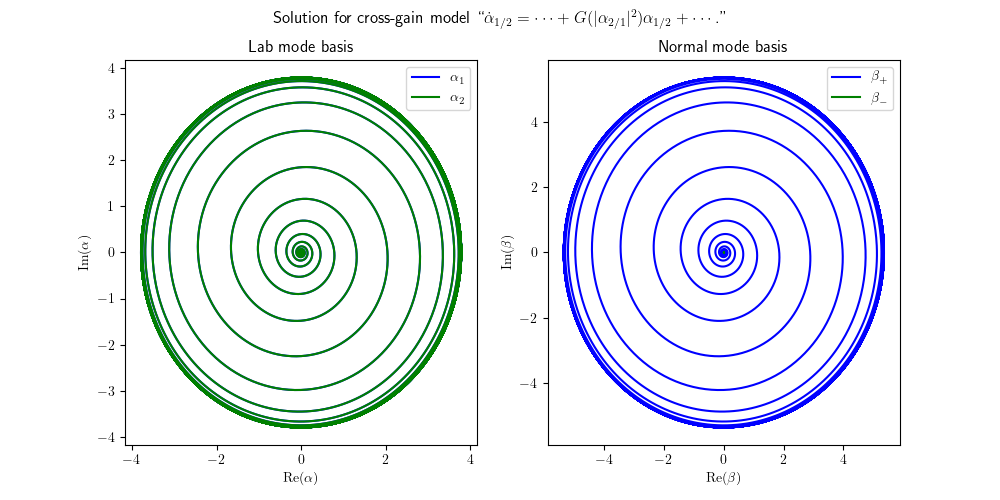

In [803]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# first in the lab mode basis
axs[0].plot(cross_gain_solution.y[0, :], cross_gain_solution.y[1, :], 'b-', label=r'$\alpha_1$')
axs[0].plot(cross_gain_solution.y[2, :], cross_gain_solution.y[3, :], 'g-', label=r'$\alpha_2$')
axs[0].set_title('Lab mode basis')
axs[0].set_xlabel(r'$\mathrm{Re}(\alpha)$')
axs[0].set_ylabel(r'$\mathrm{Im}(\alpha)$')
axs[0].legend()

# now in the normal mode basis
alpha_1s_ = cross_gain_solution.y[0, :] + 1j * cross_gain_solution.y[1, :]
alpha_2s_ = cross_gain_solution.y[2, :] + 1j * cross_gain_solution.y[3, :]
beta_ps_, beta_ms_ = lab_to_normal_amplitudes(alpha_1s_, alpha_2s_)
axs[1].plot(np.real(beta_ps_), np.imag(beta_ps_), 'b-', label=r'$\beta_{+}$')
axs[1].plot(np.real(beta_ms_), np.imag(beta_ms_), 'g-', label=r'$\beta_{-}$')
axs[1].set_xlabel(r'$\mathrm{Re}(\beta)$')
axs[1].set_ylabel(r'$\mathrm{Im}(\beta)$')
axs[1].set_title('Normal mode basis')
axs[1].legend()

# set a sup title
fig.suptitle(r"Solution for cross-gain model ``$\dot{\alpha}_{1/2} = \cdots + G(|\alpha_{2/1}|^2) \alpha_{1/2} + \cdots$.''")

Text(0.5, 0.98, "Solution for on-site gain model ``$\\dot{\\alpha}_{1/2} = \\cdots + G(|\\alpha_{1/2}|^2) \\alpha_{1/2} + \\cdots$''.")

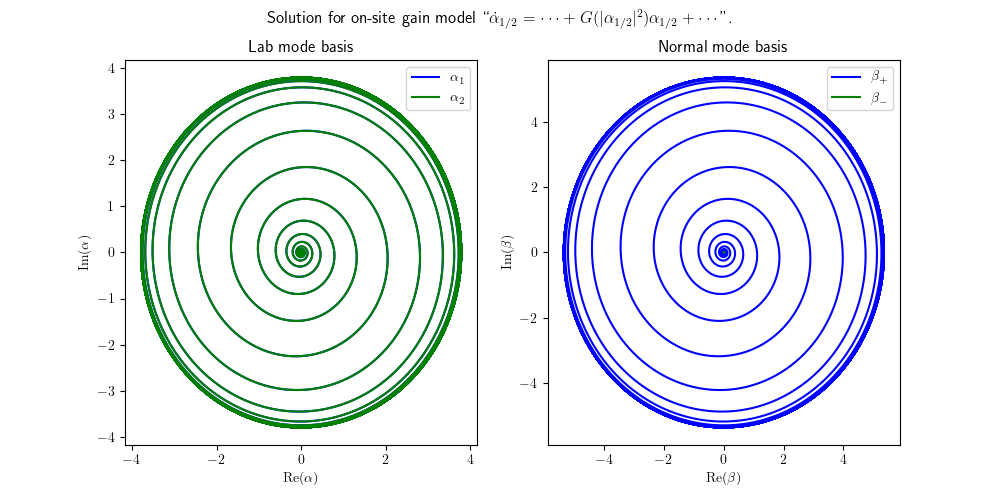

In [804]:
# Now I want to plot the result in the normal mode basis, on the left, and in the lab mode basis on the right.
# one color is then either for alpha_1 or beta_p, the other for alpha_2 or beta_m.
# Time is implicit of course.

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# first in the lab mode basis
axs[0].plot(onsite_gain_solution.y[0, :], onsite_gain_solution.y[1, :], 'b-', label=r'$\alpha_1$')
axs[0].plot(onsite_gain_solution.y[2, :], onsite_gain_solution.y[3, :], 'g-', label=r'$\alpha_2$')
axs[0].set_title('Lab mode basis')
axs[0].set_xlabel(r'$\mathrm{Re}(\alpha)$')
axs[0].set_ylabel(r'$\mathrm{Im}(\alpha)$')
axs[0].legend()

# now in the normal mode basis
alpha_1s_ = onsite_gain_solution.y[0, :] + 1j * onsite_gain_solution.y[1, :]
alpha_2s_ = onsite_gain_solution.y[2, :] + 1j * onsite_gain_solution.y[3, :]
beta_ps_, beta_ms_ = lab_to_normal_amplitudes(alpha_1s_, alpha_2s_)
axs[1].plot(np.real(beta_ps_), np.imag(beta_ps_), 'b-', label=r'$\beta_{+}$')
axs[1].plot(np.real(beta_ms_), np.imag(beta_ms_), 'g-', label=r'$\beta_{-}$')
axs[1].set_xlabel(r'$\mathrm{Re}(\beta)$')
axs[1].set_ylabel(r'$\mathrm{Im}(\beta)$')
axs[1].set_title('Normal mode basis')
axs[1].legend()

fig.suptitle(r"Solution for on-site gain model ``$\dot{\alpha}_{1/2} = \cdots + G(|\alpha_{1/2}|^2) \alpha_{1/2} + \cdots$''.")